In [2]:
import pandas as pd
import numpy as np

# 2. Load data
data_optimasi = pd.read_csv('C:/Users/User/Documents/SKRIPSI/OPTIMASI PER PENYAKIT/Start_10,10/hasil_optimasi.csv')
data_rekam = pd.read_csv('C:/Users/User/Documents/SKRIPSI/OPTIMASI PER PENYAKIT/Start_10,10/data_rekam_medis.csv')

# Helper function kombinasi CF
def kombinasi_cf(cf_list):
    if len(cf_list) == 0:
        return 0
    combined = cf_list[0]
    for cf in cf_list[1:]:
        combined = combined + cf * (1 - combined)
    return combined

# Membuat dictionary lookup
cf_pakar_dict = {(row['kode_penyakit'], row['kode_gejala']): row['cf_pakar'] for idx, row in data_optimasi.iterrows()}
cf_optimasi_dict = {(row['kode_penyakit'], row['kode_gejala']): row['cf_optimasi'] for idx, row in data_optimasi.iterrows()}

# Grouping berdasarkan pasien
grouped = data_rekam.groupby('kode_pasien')

hasil = []

for kode_pasien, group in grouped:
    # Kumpulkan gejala dan cf_user
    gejala_pasien = group['kode_gejala'].tolist()
    cf_user_pasien = group['cf_user'].tolist()
    diagnosis_asli = group['diagnosis'].iloc[0]  # diagnosis asli (sama untuk semua baris pasien)

    # --- Diagnosis sebelum optimasi ---
    cf_per_penyakit_sebelum = {}
    for penyakit in data_optimasi['kode_penyakit'].unique():
        cf_list = []
        for gejala, cf_user in zip(gejala_pasien, cf_user_pasien):
            cf_pakar = cf_pakar_dict.get((penyakit, gejala))
            if cf_pakar is not None:
                cf_list.append(cf_user * cf_pakar)
        cf_per_penyakit_sebelum[penyakit] = kombinasi_cf(cf_list)

    # --- Diagnosis setelah optimasi ---
    cf_per_penyakit_setelah = {}
    for penyakit in data_optimasi['kode_penyakit'].unique():
        cf_list = []
        for gejala, cf_user in zip(gejala_pasien, cf_user_pasien):
            cf_optimasi = cf_optimasi_dict.get((penyakit, gejala))
            if cf_optimasi is not None:
                cf_list.append(cf_user * cf_optimasi)
        cf_per_penyakit_setelah[penyakit] = kombinasi_cf(cf_list)

    # Ambil diagnosis tertinggi
    diagnosis_sebelum = max(cf_per_penyakit_sebelum.items(), key=lambda x: x[1])
    diagnosis_setelah = max(cf_per_penyakit_setelah.items(), key=lambda x: x[1])

    hasil.append({
        'kode_pasien': kode_pasien,
        'diagnosis_asli': diagnosis_asli,
        'diagnosis_sebelum': diagnosis_sebelum[0],
        'cf_sebelum': diagnosis_sebelum[1],
        'diagnosis_setelah': diagnosis_setelah[0],
        'cf_setelah': diagnosis_setelah[1],
        'cocok_sebelum': diagnosis_sebelum[0] == diagnosis_asli,
        'cocok_setelah': diagnosis_setelah[0] == diagnosis_asli
    })

# Buat dataframe hasil
hasil_df = pd.DataFrame(hasil)

# Tambahkan kolom perbandingan cf dengan toleransi floating point
hasil_df['cf_lebih_unggul'] = hasil_df.apply(
    lambda row: 'Sama' if np.isclose(row['cf_setelah'], row['cf_sebelum'], atol=1e-6)
    else ('Optimasi Lebih Unggul' if row['cf_setelah'] > row['cf_sebelum']
    else 'Belum Optimal'),
    axis=1
)

# Tampilkan hasil
print(hasil_df)

# Simpan ke file (optional)
hasil_df.to_csv('hasil_perbandingan_diagnosis.csv', index=False)


   kode_pasien diagnosis_asli diagnosis_sebelum  cf_sebelum diagnosis_setelah  \
0        PAS01            P03               P06    0.978227               P06   
1        PAS02            P03               P07    0.951040               P06   
2        PAS03            P02               P02    0.962560               P02   
3        PAS04            P04               P04    0.891136               P04   
4        PAS05            P06               P07    0.990208               P06   
..         ...            ...               ...         ...               ...   
95       PAS95            P03               P06    0.966400               P03   
96       PAS96            P06               P06    0.985600               P06   
97       PAS97            P06               P06    0.997120               P06   
98       PAS98            P04               P04    0.928000               P04   
99       PAS99            P06               P06    0.987904               P06   

    cf_setelah  cocok_sebel

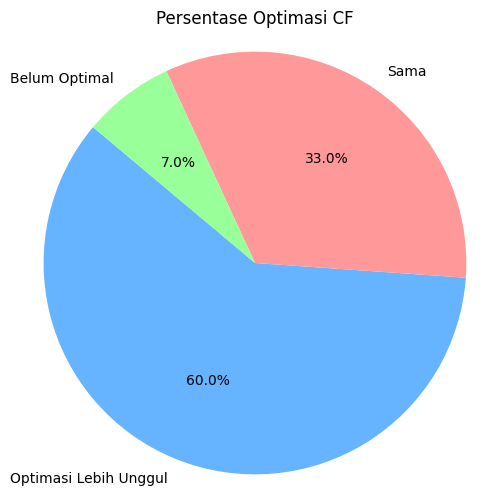

In [2]:
import matplotlib.pyplot as plt

# Pie chart cf_lebih_unggul
labels = hasil_df['cf_lebih_unggul'].value_counts().index
sizes = hasil_df['cf_lebih_unggul'].value_counts().values
colors = ['#66b3ff', '#ff9999', '#99ff99']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Persentase Optimasi CF')
plt.axis('equal')
plt.show()


                       Jumlah Pasien  Persentase (%)
cf_lebih_unggul                                     
Optimasi Lebih Unggul             60            60.0
Sama                              33            33.0
Belum Optimal                      7             7.0


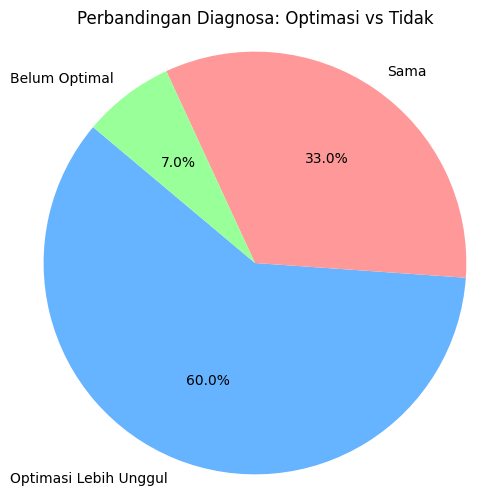

In [3]:
import matplotlib.pyplot as plt

# 1. Hitung jumlah kategori
kategori_counts = hasil_df['cf_lebih_unggul'].value_counts()
kategori_persen = hasil_df['cf_lebih_unggul'].value_counts(normalize=True) * 100

# 2. Gabungkan ke dalam DataFrame ringkasan
statistik_df = pd.DataFrame({
    'Jumlah Pasien': kategori_counts,
    'Persentase (%)': kategori_persen.round(2)
})

print(statistik_df)

# 3. Pie Chart visualisasi
plt.figure(figsize=(6,6))
plt.pie(kategori_counts, labels=kategori_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999','#99ff99'])
plt.title('Perbandingan Diagnosa: Optimasi vs Tidak')
plt.axis('equal')
plt.show()


In [4]:
# Statistik cocok_sebelum dan cocok_setelah

# Hitung total pasien
total_pasien = len(hasil_df)

# Hitung pasien cocok sebelum dan sesudah
jumlah_cocok_sebelum = hasil_df['cocok_sebelum'].sum()
jumlah_cocok_setelah = hasil_df['cocok_setelah'].sum()

# Hitung persentasenya
persen_cocok_sebelum = (jumlah_cocok_sebelum / total_pasien) * 100
persen_cocok_setelah = (jumlah_cocok_setelah / total_pasien) * 100

# Tampilkan hasil
print("Total Pasien:", total_pasien)
print("Cocok Sebelum Optimasi: {} pasien ({:.2f}%)".format(jumlah_cocok_sebelum, persen_cocok_sebelum))
print("Cocok Sesudah Optimasi: {} pasien ({:.2f}%)".format(jumlah_cocok_setelah, persen_cocok_setelah))


Total Pasien: 100
Cocok Sebelum Optimasi: 85 pasien (85.00%)
Cocok Sesudah Optimasi: 80 pasien (80.00%)


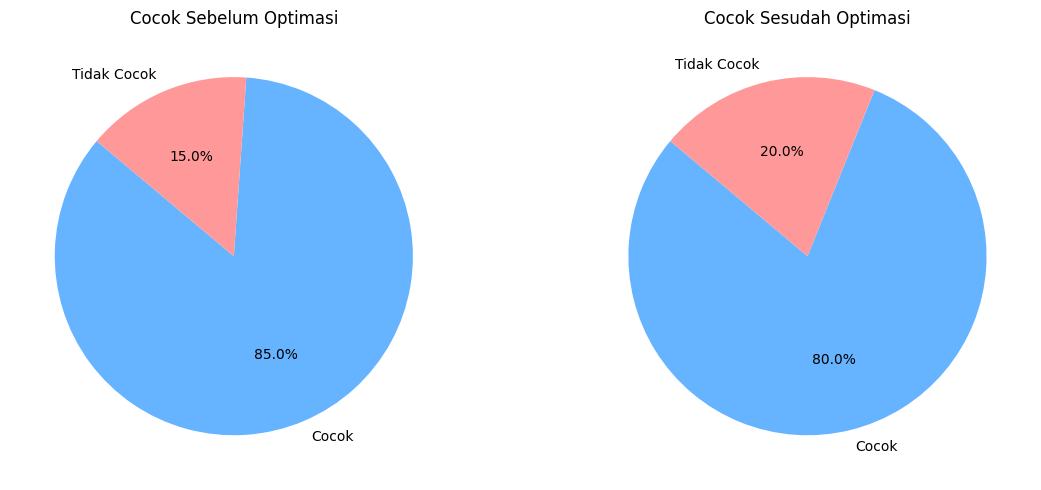

In [5]:
# Pie Chart cocok_sebelum vs cocok_setelah
labels = ['Cocok', 'Tidak Cocok']
colors = ['#66b3ff', '#ff9999']

# Pie Chart Sebelum Optimasi
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.pie([jumlah_cocok_sebelum, total_pasien - jumlah_cocok_sebelum],
        labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Cocok Sebelum Optimasi')

# Pie Chart Sesudah Optimasi
plt.subplot(1,2,2)
plt.pie([jumlah_cocok_setelah, total_pasien - jumlah_cocok_setelah],
        labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Cocok Sesudah Optimasi')

plt.tight_layout()
plt.show()
